In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
from qutip import *
import itertools as it
import matplotlib.pyplot as plt

# Autoencoder Attempt to Classify Product State

We will train an unsupervised neural network to reproduce a density matrix from a set of generated density matrices. The learning algorithm will attempt to minimize the trace distance between the original $\rho$ and the autoencoded $\rho$. While a large linear network could easily reproduce the density matrix, we will use a small, non-linear network in hopes that the compression will most easily handle product state than entangled states.

We begin by generating data from simulated density matrices.

In [30]:
N=2 # The number of qubits we're simulating
train_size = 5000 #The number of training examples we'll generate
test_size = 500 #The number of test examples

The following code performs a simulated complete tomography experiment on a given quantum state. The output of experiment gives us a $2^{2n}$ dimensional vector which represents the density matrix in the Pauli basis

In [31]:
def experiment(phi,m=100,exact=True):
    #initialization
    res = []
    s = [qeye(2), sigmax(), sigmay(), sigmaz()]
    olist = []
    for i in it.product(range(4), repeat=N):
        temp = []
        for j in i:
            temp.append(s[j])
        tempop = tensor(temp)
        olist.append(tempop)
    if exact:
        res = [expect(o,phi) for o in olist]
    
    else:
        for o in olist:
            vals, vecs = o.eigenstates()
            ps = expect(ket2dm(phi),vecs)
            ps = ps
            out = np.random.choice(vals, m, p=ps)
            res.append(np.mean(out))
    
    return res 

def gen_entangled():
    phi0 = 1/np.sqrt(2)*(tensor([basis(2,0) for dummy in range(N)]) + tensor([basis(2,1) for dummy in range(N)]))
    U = tensor([rand_unitary(2) for dummy in range(N)])
    return U*phi0 

def gen_prod():
    phi0 = tensor([basis(2,0) for dummy in range(N)])
    U = tensor([rand_unitary(2) for dummy in range(N)])
    return U*phi0

Now, we generate product state data on which to train the network

In [32]:
prod = [experiment(gen_prod()) for dummy in range(train_size)]
product_data = np.asarray(prod)

We also generate product state and entangled state data for testing the trained network

In [33]:
entangled_test = np.asarray([experiment(gen_entangled()) for dummy in range(test_size)])
product_test = np.asarray([experiment(gen_prod()) for dummy in range(test_size)])

## Autoencoder definition and training

We define a simple, single layer autoencoder. This will encode the density matrix elements into a $n_{hidden}$ dimensional vector and then attempt to approximate the original state by decoding. Below, we define the model and its parameters. Much of this code was borrowed from/inspired by https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py

In [59]:
# Network Parameters
n_hidden_1 = 4 # 1st layer num features
n_input = 4**N # Input data from all tomography results
batch_size = 50 # Define how many examples to feed in at once
batches = 100 #How many batches we train on before testing

In [60]:
X = tf.placeholder(tf.float32, [None, n_input]) #Defining the placeholder for the data

In [61]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
}

In [62]:
#Build the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),biases['encoder_b1']))
    
    return layer_1

# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.matmul(x, weights['decoder_h1'])+ biases['decoder_b1'])
    return layer_1

In [63]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

Finally, we introduce the cost function, a squared difference (which is conveniently the trace distance) and initialize the network.

In [64]:
# Define loss and optimizer, minimize the trace distance
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(.2).minimize(cost)

# Initializing the variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [65]:
for batch in range(batches):
    batch_xs = product_data[batch_size*batch:batch_size*(batch+1)].astype('float32')
    sess.run(optimizer, feed_dict={X: batch_xs})

After training, we can compute the average value of the cost function on our test data

In [66]:
print(sess.run(cost, feed_dict={X: product_test}))

0.0229283


The cost is quite low, meaning our machine is very good at approximating product states. Now we can see how it performs on entangled states.

In [67]:
print(sess.run(cost, feed_dict={X: entangled_test}))

0.25407


Unsurprisingly, the machine is terrible at approximating entangled states, but let's plot the cost for each example and see if it can distinguish the two.

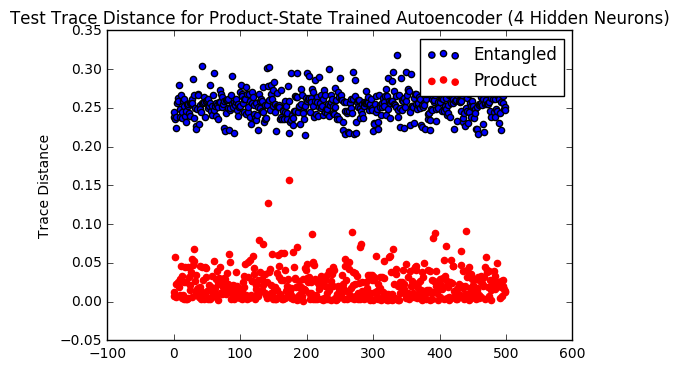

In [68]:
scatter_index = np.arange(0,test_size)
plt.scatter(scatter_index,sess.run(tf.reduce_mean(tf.pow(y_true - y_pred, 2),1),feed_dict={X: entangled_test}),
            label='Entangled')
plt.scatter(scatter_index,sess.run(tf.reduce_mean(tf.pow(y_true - y_pred, 2),1),feed_dict={X: product_test}),
            color='r',label='Product')
plt.legend()
plt.ylabel('Trace Distance')
plt.title('Test Trace Distance for Product-State Trained Autoencoder (4 Hidden Neurons)')

Here we see a full separation between product and entangled states. We could use the cost from this neural network to determine whether a given density matrix is entangled or not